In [1]:
import matplotlib.pyplot as plt 
import numpy as np
from scipy.integrate import solve_ivp

plt.rcParams['figure.figsize'] = [15, 10]


In [2]:
motor_max_torque = 1.1 #N*m, from salto after gearing
motor_max_vel = 25 #rad/s, 825kv motor geared 38.3
motor_I = 0.00000256 #kg*m^2
def get_motor_torque(t, motor_vel):
    input = 0*t + 1 # replace with better function of t
    return motor_max_torque * (input - motor_vel/motor_max_vel)

In [3]:
total_mass = 0.101 #kg
g = 9.81

def jump_model(t, s, k, get_TSA_mult, get_link_mult): #k is spring constant in N/m
    motor_pos, dmotor_pos, foot_pos, dfoot_pos = s #state

    TSA_mult = get_TSA_mult(motor_pos)
    link_mult = get_link_mult(foot_pos)

    spring_pos = -motor_pos/TSA_mult + foot_pos*link_mult

    motor_torque = get_motor_torque(t, dmotor_pos)

    spring_force = -k * spring_pos

    motor_net_torque = motor_torque - spring_force/TSA_mult
    ddmotor_pos = motor_net_torque / motor_I

    foot_applied_force = spring_force*link_mult
    ddfoot_pos = (foot_applied_force - total_mass*g) / total_mass

    if foot_pos <= 0: ddfoot_pos = max(ddfoot_pos, 0)

    return [dmotor_pos, ddmotor_pos, dfoot_pos, ddfoot_pos]

In [4]:
max_extension = 0.15 #m
def liftoff(t, s, k, get_TSA_mult, get_link_mult):
    motor_pos, dmotor_pos, foot_pos, dfoot_pos = s #state

    if foot_pos < max_extension:

        TSA_mult = get_TSA_mult(motor_pos)
        link_mult = get_link_mult(foot_pos)

        spring_pos = -motor_pos/TSA_mult + foot_pos*link_mult

        spring_force = -k * spring_pos

        foot_applied_force = spring_force*link_mult
        foot_net_force = foot_applied_force - total_mass*g
        if foot_pos <= 0: foot_net_force = max(foot_net_force, 0)


        if foot_net_force < 0:
            return 0
        else:
            return 1
    else:
        return 0
liftoff.terminal = True



In [5]:
def solve_end_vel(k, get_TSA_mult, get_link_mult, doPlot):
    t_span = (0, 0.25)
    # s0 = (0, 0, 0, 0)
    s0 = (0.1, 0, 0, 0)
    solution = solve_ivp(jump_model, t_span, s0, events=[liftoff], args=(k, get_TSA_mult, get_link_mult))

    motor_pos_data = solution.y[0, :]
    motor_vel_data = solution.y[1, :]
    foot_pos_data = solution.y[2, :]
    foot_vel_data = solution.y[3, :]



    if doPlot:
        

        TSA_mult_data = np.vectorize(get_TSA_mult)(motor_pos_data)
        link_mult_data = np.vectorize(get_link_mult)(foot_pos_data)

        spring_pos_data = -motor_pos_data/TSA_mult_data + foot_pos_data*link_mult_data

        plt.figure()
        plt.plot(solution.t, np.zeros_like(solution.t), 'k')

        plt.plot(solution.t, motor_pos_data/max(abs(motor_pos_data)), 'o', markersize=1, label=f"motor_pos {round(max(abs(motor_pos_data)),4)}")
        plt.plot(solution.t, motor_vel_data/max(abs(motor_vel_data)), label=f"motor_vel {round(max(abs(motor_vel_data)),4)}")
        plt.plot(solution.t, np.full(solution.t.shape, motor_max_vel/max(abs(motor_vel_data))), label=f"motor_max_vel")
        plt.plot(solution.t, foot_pos_data/max(abs(foot_pos_data)), label=f"foot_pos {round(max(abs(foot_pos_data)),4)}")
        plt.plot(solution.t, foot_vel_data/max(abs(foot_vel_data)), label=f"foot_vel {round(max(abs(foot_vel_data)),4)}")

        plt.plot(solution.t, TSA_mult_data/max(abs(TSA_mult_data)), '--', label=f"TSA_mult {round(max(abs(TSA_mult_data)),4)}")
        plt.plot(solution.t, link_mult_data/max(abs(link_mult_data)), '--', label=f"link_mult {round(max(abs(link_mult_data)),4)}")
        plt.plot(solution.t, -spring_pos_data/max(abs(spring_pos_data)), label=f"spring_compress {round(max(abs(spring_pos_data)),4)}")

        plt.legend()

        plt.xlabel(f"time(s) {len(solution.t)} samples")
        plt.ylabel("normalized value")
        plt.title(f"k={k}, end_foot_vel={round(foot_vel_data[-1],4)}")


        plt.figure()
        plt.plot(foot_pos_data, np.zeros_like(foot_pos_data), 'k')
        plt.plot(foot_pos_data, link_mult_data, '--', label=f"link_mult {round(max(abs(link_mult_data)),4)}")
        plt.xlabel(f"foot_pos_data (m) {len(foot_pos_data)} samples")
        plt.ylabel("link mechanical advantage")


        plt.figure()
        plt.plot(foot_vel_data, np.zeros_like(foot_vel_data), 'k')
        plt.plot(foot_vel_data, motor_vel_data)
        plt.xlabel(f"foot_vel_data (m/s) {len(foot_vel_data)} samples")
        plt.ylabel("motor vel (rad/s)")




        print('avg motor speed proportion', np.mean(motor_vel_data)/motor_max_vel)

    return foot_vel_data[-1]


avg motor speed proportion 0.4785316759361607
avg motor speed proportion 0.24280535820811688


2.3615124662124636

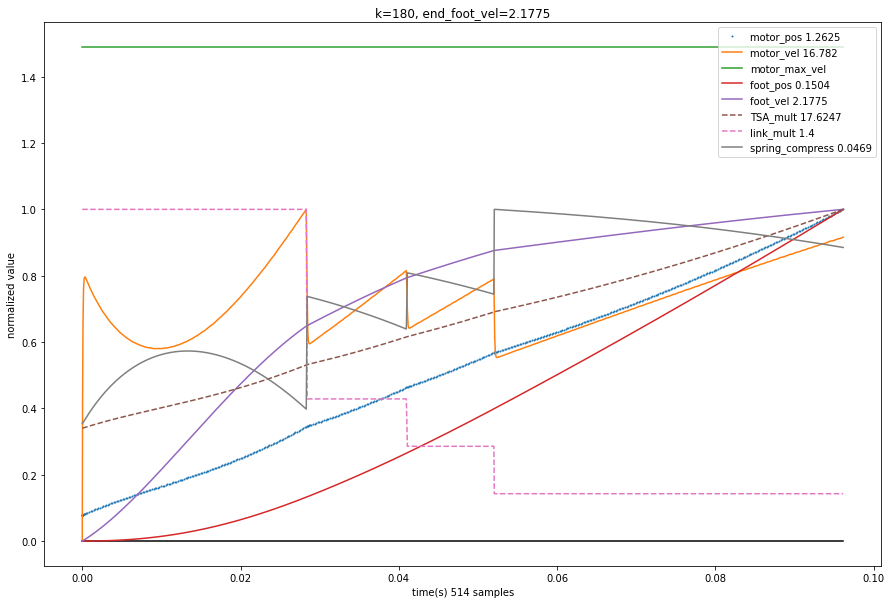

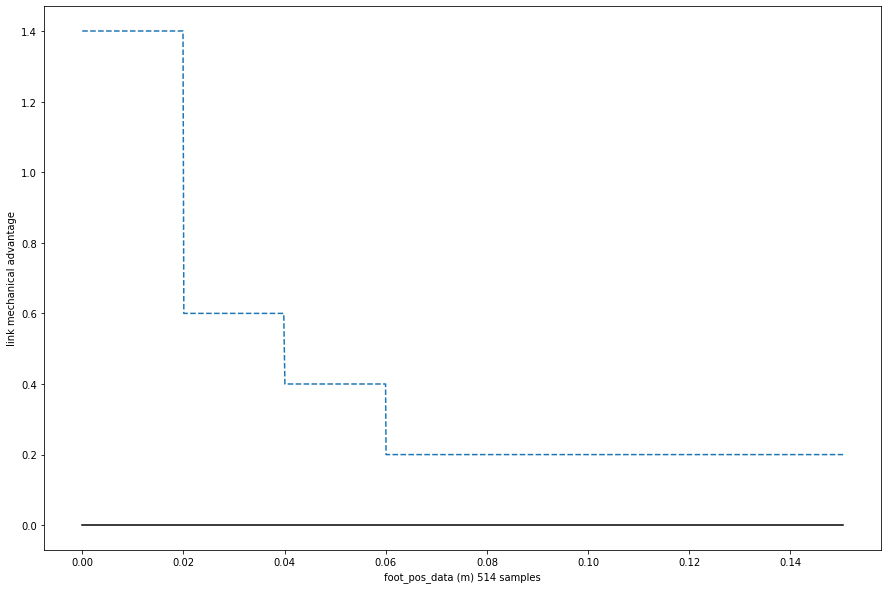

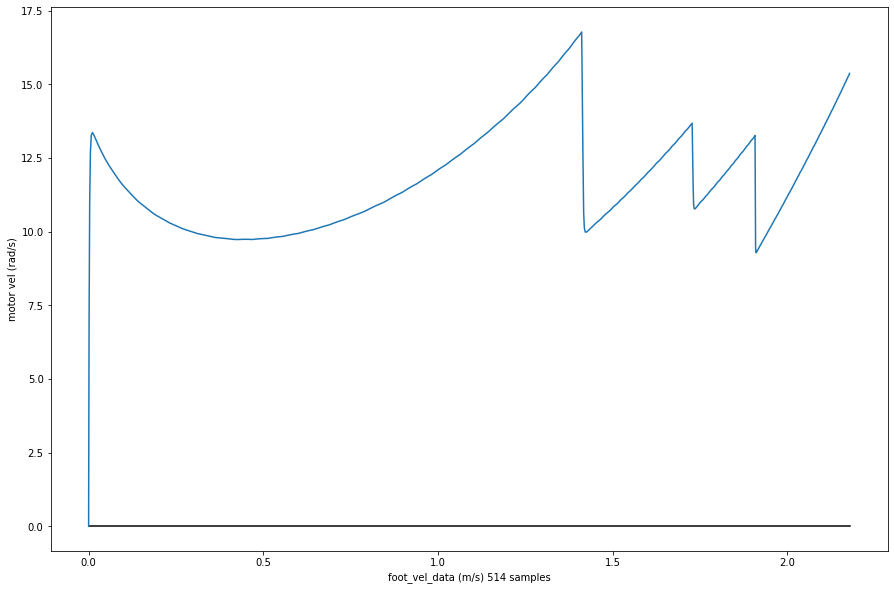

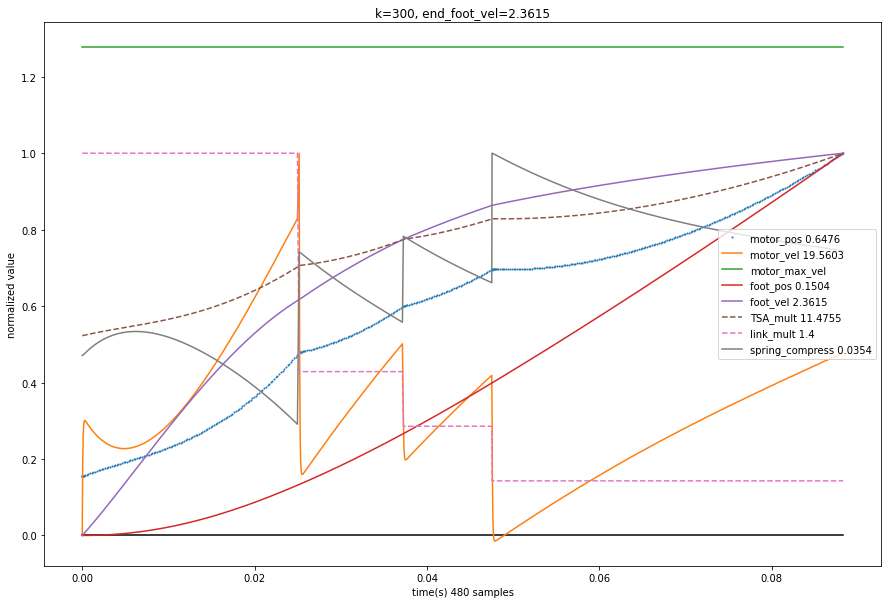

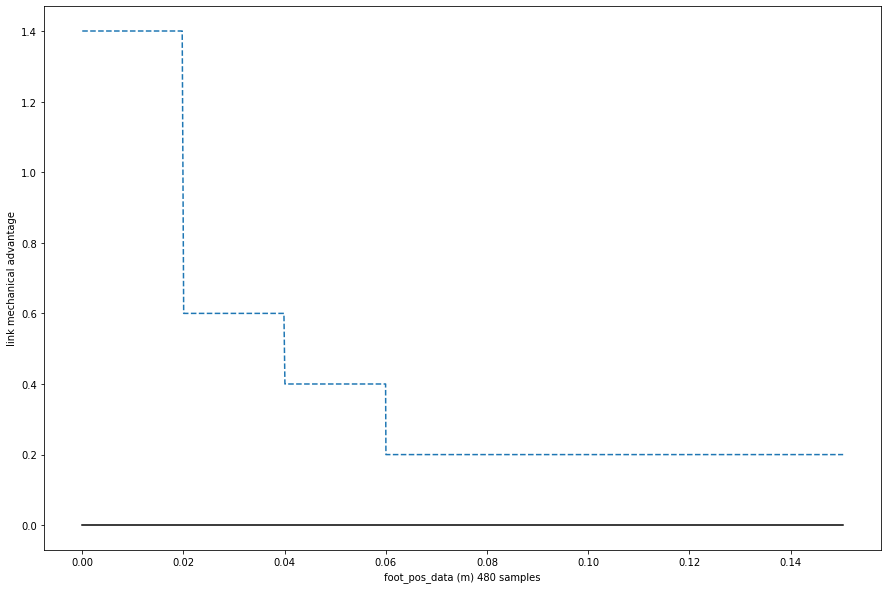

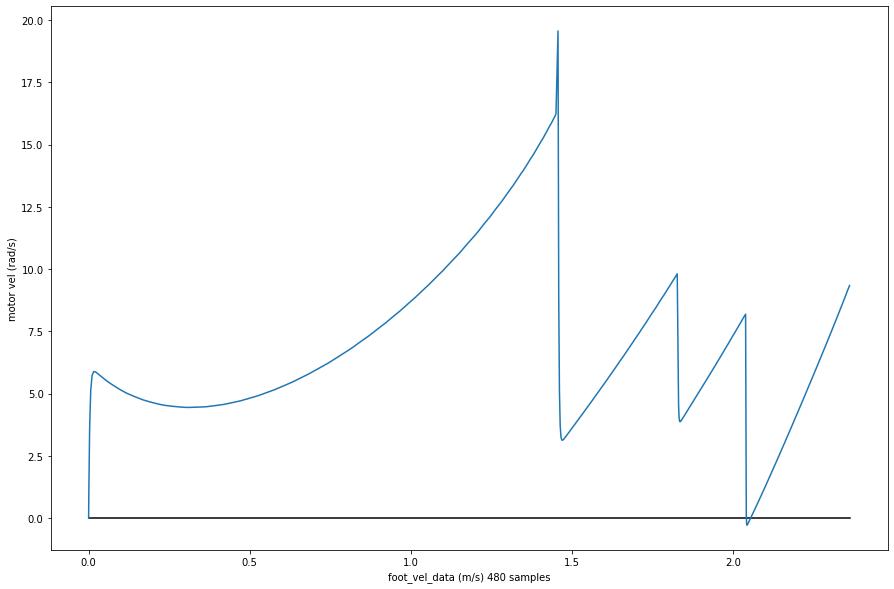

In [6]:
def get_TSA_mult(motor_pos):
    return 5 + 10*motor_pos

def get_link_mult(foot_pos):
    if foot_pos < 0.02:
        return 1.4
    elif foot_pos < 0.04:
        return 0.6
    elif foot_pos < 0.06:
        return 0.4
    else:
        return 0.2
    # return 0.1 + 4*foot_pos

# solve_end_vel(30, get_TSA_mult, get_link_mult, True) 
# solve_end_vel(50, get_TSA_mult, get_link_mult, True) 
# solve_end_vel(70, get_TSA_mult, get_link_mult, True) 
# solve_end_vel(90, get_TSA_mult, get_link_mult, True) 
# solve_end_vel(110, get_TSA_mult, get_link_mult, True) 
solve_end_vel(180, get_TSA_mult, get_link_mult, True) 
solve_end_vel(300, get_TSA_mult, get_link_mult, True) 
# solve_end_vel(300, get_TSA_mult, get_link_mult, True) 


[1.0926749029293752, 1.2285210908730049, 1.341348244628373, 1.4364554487063885, 1.5407884612670162, 1.6536670182839894, 1.7536593967070506, 1.8411071272533672, 1.9160064724362103, 1.9828029641461118, 2.0411693339162493, 2.093840418785616, 2.137576898301465, 2.1775218654397164, 2.2113050198183912, 2.2409637978875043, 2.266319430501854, 2.2876159351617678, 2.3065531639635277, 2.321201646101721, 2.3330349718656804, 2.343806930784761, 2.349386457075117, 2.3544424771176766, 2.358088703084362, 2.3615124662124636, 2.3617006567370273, 2.360187258026321, 2.358577905241324, 2.3561612354809323, 2.353262434787462, 2.3490409489728097, 2.3453272263892377, 2.3408347346658034, 2.337144767636251]


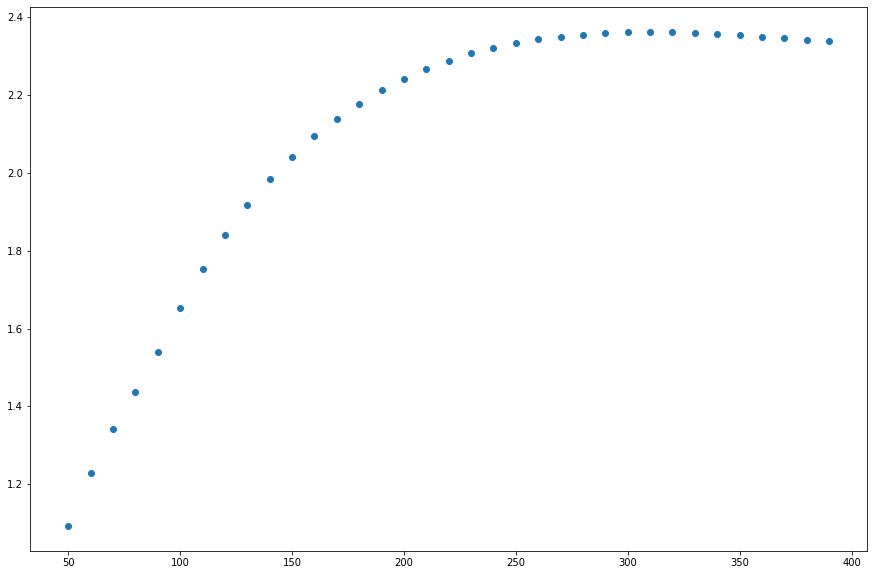

In [7]:
test_ks = np.arange(50, 400, 10)
end_vels = []

for i in test_ks:
    end_vel = solve_end_vel(i, get_TSA_mult, get_link_mult, doPlot=False)
    end_vels.append(end_vel)

print(end_vels)
plt.plot(test_ks, end_vels, 'o')

In [8]:
from scipy.optimize import minimize

In [9]:
num_divisions = 15
division_size = max_extension / num_divisions
cutoffs = np.linspace(0, max_extension, num_divisions+1)
print(cutoffs)

def objective(param, doPlot=False): #param should have length (num_divisions + 2)
    k = param[0]*500


    def get_link_mult(foot_pos):

        for i in range(num_divisions):
            if foot_pos < cutoffs[i]:
                #linear interpolation
                return param[i+1] + (foot_pos - cutoffs[i-1])/division_size * (param[i+2] - param[i+1])
                # return param[i+1]
        print('something bad happened')
        return 0
        
    return -solve_end_vel(k, get_TSA_mult, get_link_mult, doPlot=doPlot)

guesses = np.concatenate(([0.400], np.full(num_divisions + 1, 0.7)))
bounds = np.concatenate(([(0, 1)], np.full([num_divisions + 1, 2], fill_value=(0, 100))))

print(guesses)
print(bounds)
objective(guesses)

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15]
[0.4 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7]
[[  0   1]
 [  0 100]
 [  0 100]
 [  0 100]
 [  0 100]
 [  0 100]
 [  0 100]
 [  0 100]
 [  0 100]
 [  0 100]
 [  0 100]
 [  0 100]
 [  0 100]
 [  0 100]
 [  0 100]
 [  0 100]
 [  0 100]]


-1.9340208566207626

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           17     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.93402D+00    |proj g|=  4.28110D-01

At iterate    1    f= -2.06487D+00    |proj g|=  7.04883D-01

At iterate    2    f= -2.20227D+00    |proj g|=  3.35315D-01

At iterate    3    f= -2.25889D+00    |proj g|=  2.17834D-01

At iterate    4    f= -2.41230D+00    |proj g|=  3.14477D-01
[0.69413508 0.7        0.49849121 1.14188118 1.1736647  0.99646783
 0.79625665 0.62138442 0.55871419 0.52195351 0.42583709 0.30990468
 0.628509   0.7        0.7        0.7        0.7       ]

At iterate    5    f= -2.42300D+00    |proj g|=  3.05865D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
P

-2.4230014618195423

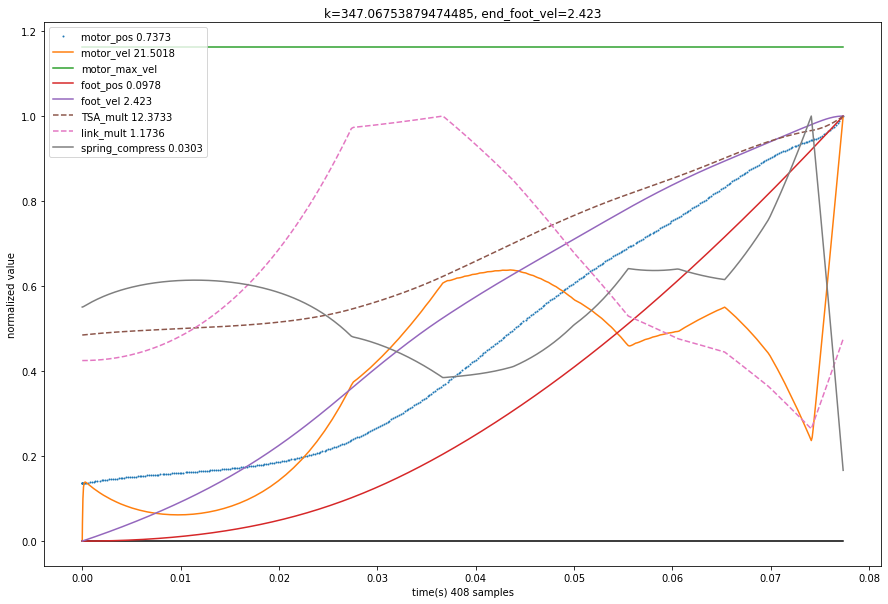

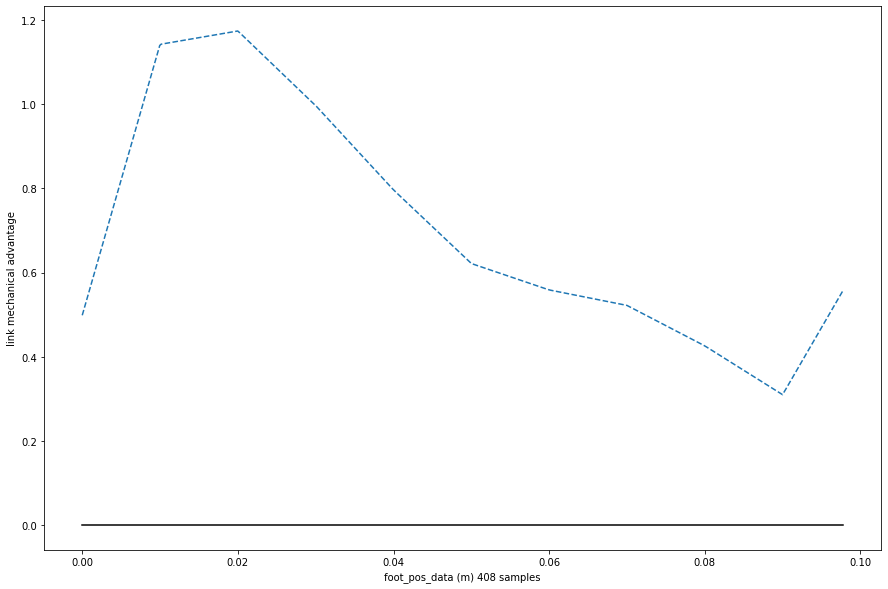

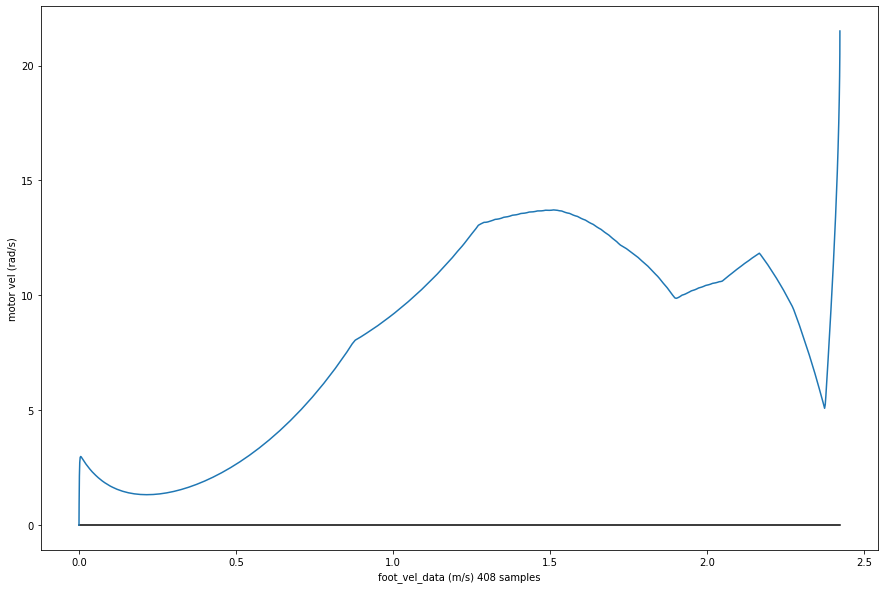

In [10]:
res = minimize(objective, guesses, bounds=bounds, options={'disp':True}, tol=1e-2)
print(res['x'])
objective(res['x'], doPlot=True)

avg motor speed proportion 0.32534020629237953


-2.4230014618195423

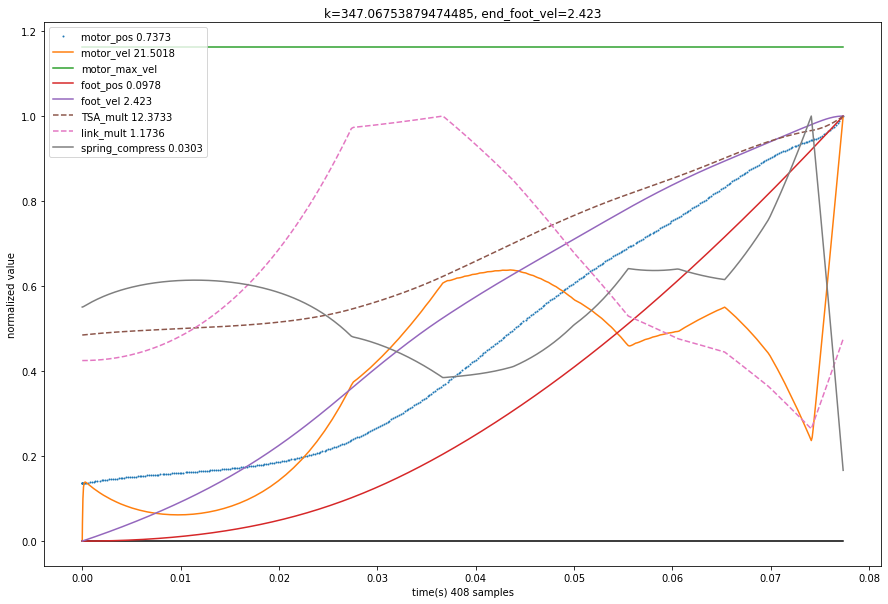

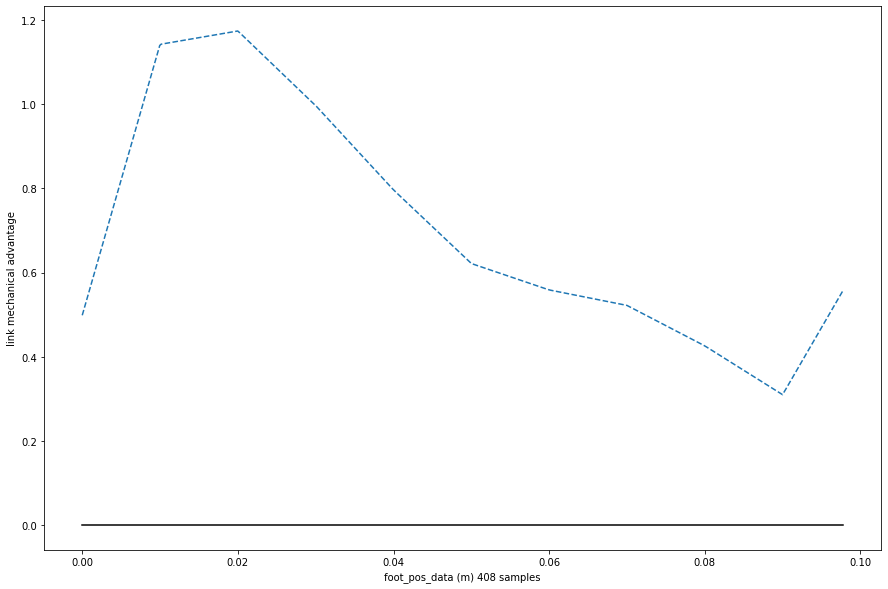

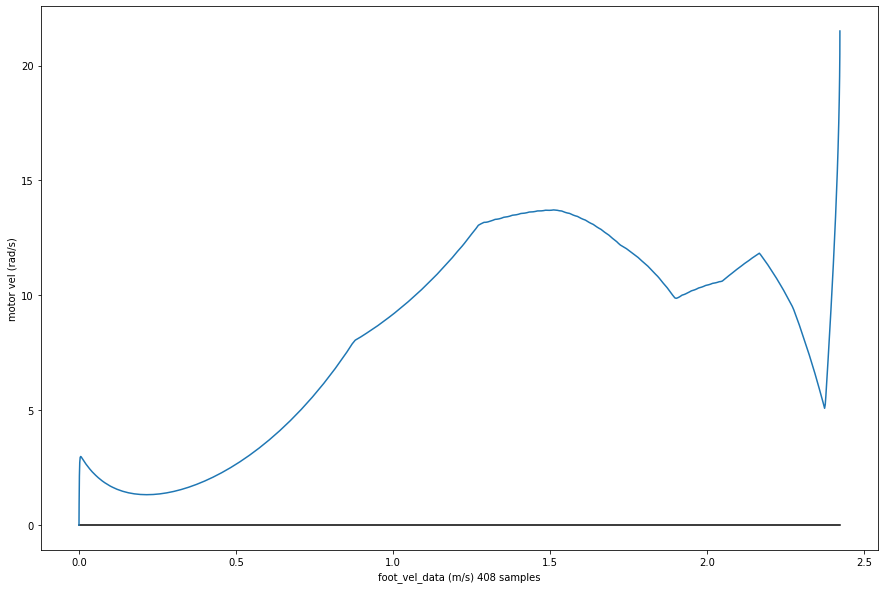

In [11]:
objective(res['x'], doPlot=True)

In [12]:
get_link_mult = lambda x: 0.7

def find_best_k(get_link_mult):
    def k_objective(k):
        return -solve_end_vel(k, get_TSA_mult, get_link_mult, doPlot=False)

    res = minimize(fun=k_objective, x0=180, options={'disp':True})
    return res['x']

print(find_best_k(get_link_mult))

Optimization terminated successfully.
         Current function value: -1.934890
         Iterations: 4
         Function evaluations: 22
         Gradient evaluations: 11
[191.314098]


In [13]:
#optimize link_mult profile
num_divisions = 10
division_size = max_extension / num_divisions
cutoffs = np.linspace(0, max_extension, num_divisions+1)
print(cutoffs)

def objective(param, doPlot=False): #param should have length (num_divisions + 2)
    k = param[0]*500


    def get_link_mult(foot_pos):

        for i in range(num_divisions):
            if foot_pos < cutoffs[i]:
                #linear interpolation
                return param[i+1] + (foot_pos - cutoffs[i-1])/division_size * (param[i+2] - param[i+1])
                # return param[i+1]
        print('something bad happened')
        return 0
        
    return -solve_end_vel(k, get_TSA_mult, get_link_mult, doPlot=doPlot)

guesses = np.concatenate(([0.400], np.full(num_divisions + 1, 0.7)))
bounds = np.concatenate(([(0, 1)], np.full([num_divisions + 1, 2], fill_value=(0, 100))))

# print(guesses)
# print(bounds)
print("initial:", objective(guesses))

[0.    0.015 0.03  0.045 0.06  0.075 0.09  0.105 0.12  0.135 0.15 ]
initial: -1.9340208566207626


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           12     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.93402D+00    |proj g|=  5.59610D-01

At iterate    1    f= -2.05009D+00    |proj g|=  7.04883D-01

At iterate    2    f= -2.21761D+00    |proj g|=  5.28438D-01

At iterate    3    f= -2.32547D+00    |proj g|=  3.40713D-01

At iterate    4    f= -2.55066D+00    |proj g|=  2.69849D-01

At iterate    5    f= -2.62288D+00    |proj g|=  3.44195D-01

At iterate    6    f= -2.65882D+00    |proj g|=  3.22552D-01
[1.         0.7        0.87660662 1.94587589 1.50064102 0.78734926
 0.61263302 0.57462653 0.         0.21109218 0.69958163 0.7       ]
At iterate    7    f= -2.67567D+00    |proj g|=  8.17169D+00


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped

-2.6756704555736963

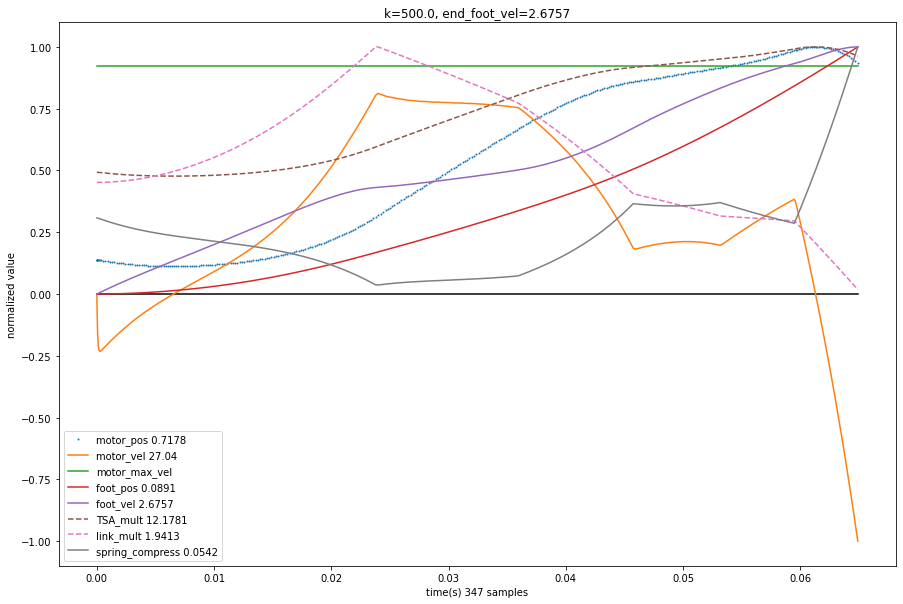

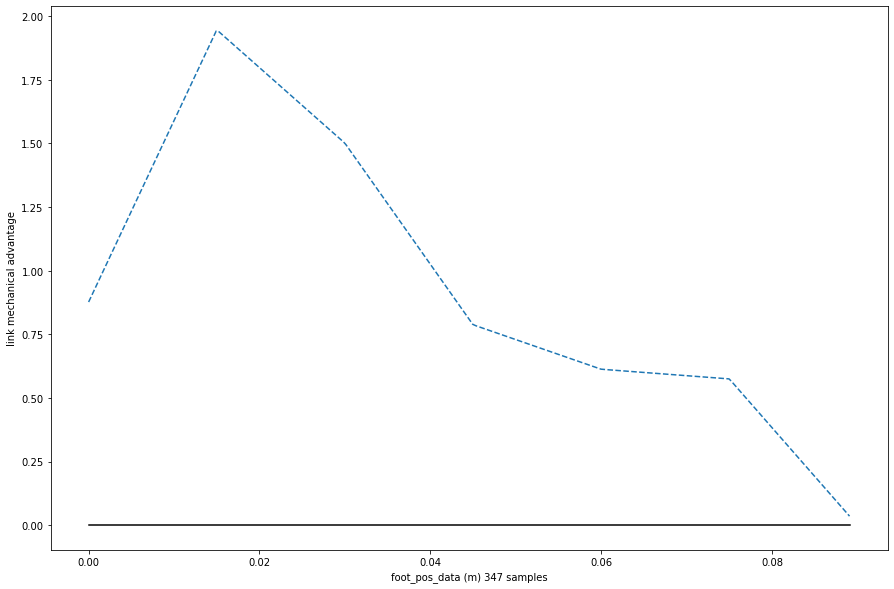

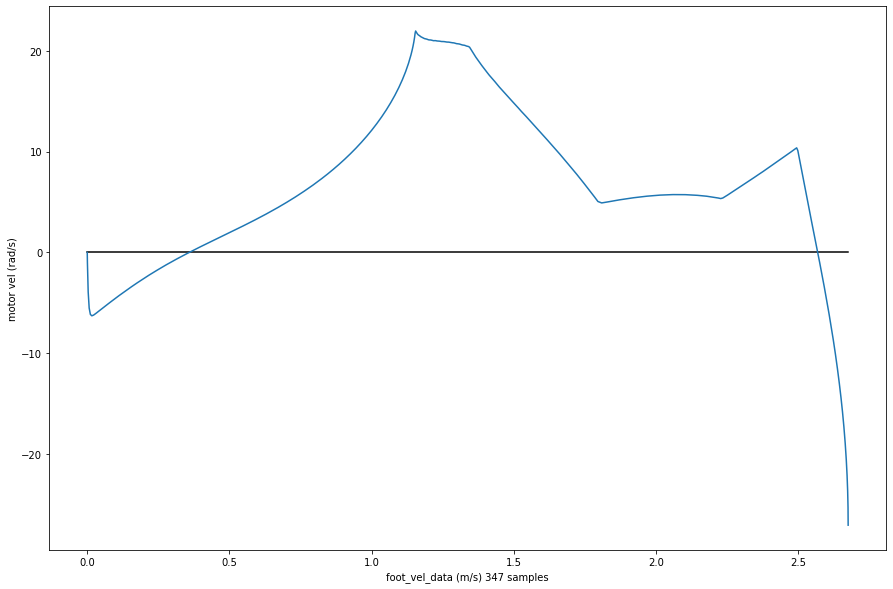

In [14]:
res = minimize(objective, guesses, bounds=bounds, options={'disp':True}, tol=1e-2)
print(res['x'])
objective(res['x'], doPlot=True)